<a href="https://colab.research.google.com/github/jimi20709/Forest-Model/blob/main/new2_%E6%A3%AE%E6%9E%97%E5%85%89%E5%90%88%E4%BD%9C%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import math # simulate 函数和太阳高度角计算需要 math 函数
import numpy as np # 光合作用函数需要 numpy
import scipy.integrate as spi # 光合作用函数需要 scipy.integrate
import pytz # 用于处理时区信息

# 这是一个计算太阳高度角的函数，基于一年中的天数和时角
def calculate_solar_altitude_alt(year, month, day, hour, minute, second, latitude, longitude, tz_offset_hours):
    """
    计算给定时间地点下太阳的高度角 (角度，0度为地平线，90度为天顶)。
    使用基于日序数和时角计算的简化方法。

    参数:
        year, month, day, hour, minute, second (int): 日期和时间 (本地时间)。
        latitude (float): 地点纬度 (十进制度数)。北半球为正，南半球为负。
        longitude (float): 地点经度 (十进制度数)。东半球为正，西半球为负。
        tz_offset_hours (float): 相对于 UTC 的时区偏移小时数 (例如，UTC+8 为 8.0)。

    返回:
        float: 太阳高度角 (度)，如果太阳在地平线以下则为负值。
               如果计算失败则返回 None。


try:: 標示你希望“試著執行看看”，而且可能會出錯的程式碼區塊。
except:: 標示“如果 try 區塊出錯了，就執行這裡的程式碼”的應急處理區塊。
    """
    try:
        # 创建本地时间 datetime 对象,(from row2)
        date_obj = datetime(year, month, day, hour, minute, second)

        # 计算一年中的天数 (Julian Day equivalent for simplified calculations)
        #   date_obj 是之前用年、月、日等建立起來的一個物件。
        #   .timetuple()：這是一個方法，用來從 date_obj 物件中獲取一個包含日期時間信息的元組 (tuple)。你可以暫時把它想成是從日期時間物件裡“拿出”更多詳細資訊的一個動作。
        #   .tm_yday: 這是從上面拿出來的那個元組裡面的一個屬性，它儲存的就是這一天是當年的第幾天（例如 1 月 1 日就是 1）。
        day_of_year = date_obj.timetuple().tm_yday

        # 计算日角 Gamma (以弧度表示)
        # 这是基于一年365天的近似，对于闰年会有少量误差
        gamma = 2 * math.pi * (day_of_year - 1 + (hour - 12) / 24) / 365.0

        # 计算太阳赤纬 (Declination) (以度表示)
        # 使用简化的公式
        #   - \: 不是運算符號，而是 Python 中用來續行的符號。表示這行程式碼還沒結束，會在下一行繼續。這只是為了讓程式碼看起來不那麼長，更容易閱讀。
        declination_rad = 0.006918 - 0.399912 * math.cos(gamma) + 0.070257 * math.sin(gamma) - \
                          0.006758 * math.cos(2 * gamma) + 0.000907 * math.sin(2 * gamma) - \
                          0.002697 * math.cos(3 * gamma) + 0.00148 * math.sin(3 * gamma)
        # degrees() 函式，將括號裡面的值轉換成度數
        declination_deg = math.degrees(declination_rad)


        # 计算时间标准子午线 (以度表示)
        standard_meridian = tz_offset_hours * 15.0

        # 计算时差 (Equation of Time) (以分钟表示)
        # 这是基于 NREL 简化算法的 EoT 公式
        eot_minutes = 2.2918 * (0.0075 + 0.1868 * math.cos(gamma) - 3.2077 * math.sin(gamma) -
                                 1.4615 * math.cos(2 * gamma) - 4.089 * math.sin(2 * gamma))

        # 计算地方真太阳时 (Local Apparent Solar Time, LAST)
        # 首先计算当前本地时间的小时数（包括小数）
        local_time_hours_decimal = hour + minute / 60.0 + second / 3600.0

        # 计算地方真太阳时的小时数
        # Local Solar Time = Local Standard Time + EoT/60 + (Longitude - Standard Meridian)/15
        solar_time_hours = local_time_hours_decimal + eot_minutes/60.0 + (longitude - standard_meridian)/15.0

        # 计算时角 (Hour Angle) (以度表示)
        # 时角是太阳相对于地方子午线的角度，正午时为 0 度
        # 每小时地球自转 15 度
        hour_angle_deg = (solar_time_hours - 12.0) * 15.0

        # 计算太阳高度角 (Altitude) (以度表示)
        # 使用标准的天文公式: sin(h) = sin(lat)sin(dec) + cos(lat)cos(dec)cos(H)
        latitude_rad = math.radians(latitude)   #將緯度從度數轉換為弧度，儲存在 latitude_rad 變數中。這是因為三角函數 math.sin(), math.cos() 需要使用弧度。
        hour_angle_rad = math.radians(hour_angle_deg)

        sin_altitude = math.sin(latitude_rad) * math.sin(declination_rad) + \
                       math.cos(latitude_rad) * math.cos(declination_rad) * math.cos(hour_angle_rad)

        # 由于浮点计算误差，sin_altitude 可能略微超出 [-1, 1]，需要 clamp
        sin_altitude = max(-1.0, min(1.0, sin_altitude))    #min(1.0, sin_altitude): 呼叫內建的 min() 函式，比較 1.0 和 sin_altitude 的值，取較小的那一個。這能確保結果不會超過 1.0。
                                      #max(-1.0, ...): 呼叫內建的 max() 函式，比較 -1.0 和上面 min() 函式的結果，取較大的那一個。這能確保結果不會小於 -1.0。
        altitude_deg = math.degrees(math.asin(sin_altitude))

        return altitude_deg

    except Exception as e:
        print(f"计算太阳高度角 (Alt) 时发生错误: {e}")
        return None

# return result: 用於函式成功執行並產生了一個你需要用到的具體結果。
# return None:
#   用來表示函式未能成功完成任務，或者沒有得到一個有效的結果（常與錯誤處理一起使用）。
#   或者，用於那些主要作用是執行動作(e.g.: print() )，而不回傳特定計算結果的函式（此時不寫 return 也會預設回傳 None）。


In [ ]:
# --- 第二个代码单元格内容: 光合作用模拟、执行与绘图 ---


# calculate_sunshade_canopy_photosynthesis函数

# --- 常量 ---
R = 8.314 # 气体常数 (J / mol / K)
O2_pressure_pa = 21000.0 # 氧气分压 (Pa)，标准大气压下约为 21 kPa

# --- 标准温度响应参数 (基于 Bernacchi et al. 或类似来源的典型值) ---
T_ref_k = 298.15 # 参考温度 (25°C) (K)

# Vcmax的温度响应参数 (Ha, Hd, DeltaS)
Ha_Vcmax = 65300.0 # 活化能 (J/mol)
Hd_Vcmax = 200000.0 # 失活能 (J/mol)
DeltaS_Vcmax = 650.0 # 熵变项 (J/mol/K)

# Jmax的温度响应参数 (Ha, Hd, DeltaS)
Ha_Jmax = 43540.0 # 活化能 (J/mol)
Hd_Jmax = 200000.0 # 失活能 (J/mol)
DeltaS_Jmax = 650.0 # 熵变项 (J/mol/K)

# Kc (CO2 Michaelis-Menten constant) 的温度响应参数 (Ha)
Kc_ref_pa = 40.49 # 参考温度 (25°C) 下的值 (Pa) (对应 404.9 ubar)
Ha_Kc = 80990.0 # 活化能 (J/mol)

# Ko (O2 Michaelis-Menten constant) 的温度响应参数 (Ha)
Ko_ref_pa = 27840.0 # 参考温度 (25°C) 下的值 (Pa) (对应 278.4 mbar)
Ha_Ko = 36380.0 # 活化能 (J/mol)

# GammaStar (CO2 Compensation Point) 的温度响应参数 (Ha)
GammaStar_ref_pa = 3.74 # 参考温度 (25°C) 下的值 (Pa) (对应 3.74 ubar)
Ha_GammaStar = 46390.0 # 活化能 (J/mol)

# Rd (Dark Respiration) 的温度响应参数 (简化为Arrhenius形式)
Ha_Rd = 46390.0 # 通常Rd的活化能与GammaStar相似

# Farquhar模型参数 (补充论文中叶片模型部分未列出的参数)
alpha_j = 0.3 # 光合作用的量子产额 (mol electron / mol photon)
theta_j = 0.9 # 电子传递的光响应曲线的弯曲度参数

# 叶片光学属性 (简化)
leaf_absorptance_par = 0.8 # 叶片对PAR的吸收率 (无单位)

# ---定义可以重复使用的计算函数---

def arrhenius_response(param_ref, T_k, Ha, T_ref=T_ref_k, R=R):
    """Arrhenius 温度响应"""
    return param_ref * np.exp(Ha * (T_k - T_ref) / (R * T_k * T_ref))

def peaked_temp_response(param_ref, T_k, Ha, Hd, DeltaS, T_ref=T_ref_k, R=R):
    """考虑热失活的峰形温度响应"""
    if T_k <= 0:    # 这是第一个安全检查或者说是处理无效/极端输入，温度 T_k 是开尔文温度，0 K 是绝对零度。
        return 0.0
    term1 = arrhenius_response(1.0, T_k, Ha, T_ref, R)
    term2 = (1 + np.exp((DeltaS * T_ref - Hd) / (R * T_ref)))
    term3 = (1 + np.exp((DeltaS * T_k - Hd) / (R * T_k)))
    if term3 <= 1e-9: # 这是第二个安全检查，防止出现数学错误，
    # term3 作为除数，如果值非常接近或等于 0，进行除法运算会导致结果变得无穷大
         return 0.0
    return param_ref * term1 * term2 / term3

    """
    你可以想象 param_ref 是这个机器在正常温度下的“基础速度”。
    term1 就像是温度升高给机器打的“加速剂”倍数（温度越高，加速剂效果越强）。
    term2 / term3 就像是温度对机器造成的“磨损/故障率”修正因子（温度太高，磨损/故障加剧，这个因子就变小）
    最终的速度 = 基础速度 × 加速剂倍数 × 磨损修正因子
    """

# --- 叶片级参数温度调整 ---
"""
adjust_leaf_params_for_temperature 函数的目的是：

当你告诉我当前的温度是多少，并且告诉我这些参数在参考温度(25'C)下的“基准值”是多少时，它就能计算出这些参数在“当前温度”下的实际值。
"""
def adjust_leaf_params_for_temperature(T_k, params_ref):    # params_ref 字典，里面存放着各个叶片参数在参考温度下的基准值。
    """根据温度调整叶片级光合参数到当前温度下的值"""
    Vcmax_T = peaked_temp_response(params_ref['Vcmax_ref'], T_k, Ha_Vcmax, Hd_Vcmax, DeltaS_Vcmax)  # 调用前面的峰形温度响应函数 peaked_temp_response()
    Jmax_T = peaked_temp_response(params_ref['Jmax_ref'], T_k, Ha_Jmax, Hd_Jmax, DeltaS_Jmax)
    Kc_T = arrhenius_response(params_ref['Kc_ref'], T_k, Ha_Kc)                    # 使用 Arrhenius 温度响应函数
    Ko_T = arrhenius_response(params_ref['Ko_ref'], T_k, Ha_Ko)
    GammaStar_T = arrhenius_response(params_ref['GammaStar_ref'], T_k, Ha_GammaStar)
    Rd_T = arrhenius_response(params_ref['Rd_ref'], T_k, Ha_Rd)

    return {
        'Vcmax_T': Vcmax_T, # μmol m-2 s-1
        'Jmax_T': Jmax_T,    # μmol m-2 s-1
        'Kc_T': Kc_T,        # Pa
        'Ko_T': Ko_T,        # Pa
        'GammaStar_T': GammaStar_T, # Pa
        'Rd_T': Rd_T         # μmol m-2 s-1
    }

# --- 冠层结构和光照计算 ---
def calculate_sunlit_fraction(Lc, kb):
    """计算冠层受光叶面积指数 (使用论文公式 18)"""
    # L_sun = (1 - exp(-kb * Lc)) / kb
    # 当太阳高度角非常高时，kb 会接近非常小（接近于零）
    if kb is None or kb <= 1e-9:
         if kb is None or kb < 0: # 如果太阳在地平线以下，可能会被设为 None
             return 0.0
         elif kb < 1e-9: # 如果 kb 非常小, L_sun = L_c
             return Lc
         else: # Should not happen with kb > 1e-9 but included for completeness(如果 kb 在 0 到 1e-9 之间（非常小的正数），使用主公式)
             return (1.0 - np.exp(-kb * Lc)) / kb # main formula

    # Main case for kb > 1e-9
    return (1.0 - np.exp(-kb * Lc)) / kb


# 用于积分的函数：深度 L 处的受光叶片比例 (使用论文公式 A1)
def f_sun(L, kb):
    """受光叶片比例廓线"""
    # For kb near zero, exp(-kb*L) approx 1 - kb*L
    if kb is None or kb < 1e-9:
         if kb is None or kb < 0: return 0.0    #如果 kb 是 None 或负数，返回 0.0
         return 1.0     #如果 kb 非常小（在 1e-9 附近或更小，排除了 None 和负数），函数直接返回 1.0。
    return np.exp(-kb * L)   #在 kb 大于等于 1e-9 时执行

# 用于积分的函数：深度 L 处的遮荫叶片比例
def f_shade(L, kb):
    """遮荫叶片比例廓线"""
    return 1.0 - f_sun(L, kb)

# 用于积分的函数：叶片光合能力/呼吸速率随深度变化 (基于指数衰减假设)
def profile_exp_decay(L, top_value_T, kn):
    """指数衰减廓线"""
    if kn is None or kn < 0:
        return 0.0
    return top_value_T * np.exp(-kn * L)

# 计算受光/遮荫叶片的平均光照和能力 (基于指数衰减和积分的简化方法)
# 接收计算好的 kb, Ib0, Id0, kdp_eff
def calculate_average_light_and_capacity(Lc, kb, kn, Ib0, Id0, kdp_eff, Vcmax_top_ref, Jmax_top_ref, Rd25_top, Kc_ref_pa, Ko_ref_pa, GammaStar_ref_pa, T_k):
    """
    根据冠层的总体情况（总叶面积、光照类型、叶片能力随深度变化等）
    计算受光和遮荫叶片的平均吸收PAR、平均光合能力和呼吸速率。
    """
    # max(0.0, variable): 这是一个常用的编程技巧，用来确保一个数值不会小于 0。
    # 如果 variable 的值小于 0，max 函数就会返回 0.0；否则，就返回 variable 本身的值
    Lc = max(0.0, Lc)
    Ib0 = max(0.0, Ib0)
    Id0 = max(0.0, Id0)
    kdp_eff = max(1e-9, kdp_eff) # kdp_eff should be > 0 for extinction
    kn = max(0.0, kn) # kn can be 0 if capacity is uniform

    # kb can be 0 or small if beta is 90 or near 90
    # If kb is None (from solar angle error) or negative, treat as effectively infinite extinction for direct light, meaning no sunlit leaves
    if kb is None or kb < 0:
        L_sun = 0.0
        L_shade = Lc
    else:
        L_sun = calculate_sunlit_fraction(Lc, kb)
        L_sun = min(Lc, max(0.0, L_sun))    # max(0.0, L_sun) 确保了计算出来的 L_sun 至少是 0
                              # min() 确保了经过前面 max 处理后的 L_sun 不会大于 Lc
        L_shade = Lc - L_sun
        L_shade = max(0.0, L_shade)


    # --- 计算平均吸收PAR (简化方法) ---
    # 深度 L 处的入射直射 PAR (简化)
    def incident_Ib_simplified(L, Ib0_val, kb_val):
        if kb_val is None or kb_val < 0: return 0.0 # No direct light penetration if kb invalid
        return Ib0_val * np.exp(-kb_val * L)
    # 深度 L 处的入射漫射 PAR (简化，使用有效消光系数)
    def incident_Id_simplified(L, Id0_val, kdp_eff_val):
        # Ensure kdp_eff_val is positive for extinction
        if kdp_eff_val <= 1e-9: # Treat very small kdp as no extinction for diffuse
             return Id0_val if Lc > 0 else 0.0 # 值1 if 条件 else 值2: 这是 Python 中的一种简洁的条件表达式（三元运算符（Ternary Operator））
                                  # Python 会先判断 if 后面的 条件是否为真 ，主要目的是产生一个值，而不是执行一段复杂的代码。
        return Id0_val * np.exp(-kdp_eff_val * L)

    # 深度 L 处的吸收 PAR 廓线 (简化) - Note: This is INCIDENT PAR profile, needs leaf absorptance
    # A better approach is to integrate absorbed PAR = incident * leaf_absorptance
    # Correct absorption profile:
    def absorbed_PAR_profile_sunlit(L, Ib0_val, Id0_val, kb_val, kdp_eff_val, leaf_abs):
        # Sunlit leaves absorb both direct and diffuse at depth L
        incident_direct = incident_Ib_simplified(L, Ib0_val, kb_val)
        incident_diffuse = incident_Id_simplified(L, Id0_val, kdp_eff_val)
        return (incident_Ib_simplified(L, Ib0_val, kb_val) + incident_Id_simplified(L, Id0_val, kdp_eff_val)) * leaf_abs * f_sun(L, kb_val)

    def absorbed_PAR_profile_shaded(L, Id0_val, kdp_eff_val, leaf_abs, kb_val):
         return incident_Id_simplified(L, Id0_val, kdp_eff_val) * leaf_abs * f_shade(L, kb_val) # Only consider diffuse light

    # Integrate total absorbed PAR over the canopy depth (per ground area)
    """
    spi.quad 函数只接受一个积分变量（这里用 L）作为输入的函数。
    但是我们计算吸收 PAR 贡献率 (absorbed_PAR_profile_sunlit) 的函数需要很多输入（L, Ib0, Id0, kb, kdp_eff, leaf_absorptance_par）。
    lambda L的作用就像一个包装容器

    ---使用 def---
    def add_ten_def(x):
        return x + 1

    ---使用 lambda---
    add_ten_lambda = lambda x: x + 10
    ==================
    print(add_ten_def(5))    # 输出: 15
    print(add_ten_lambda(5)) # 输出: 15

    """
    if Lc > 1e-9:
        total_absorbed_sunlit_ground_area = spi.quad(lambda L: absorbed_PAR_profile_sunlit(L, Ib0, Id0, kb, kdp_eff, leaf_absorptance_par), 0, Lc)[0]
        total_absorbed_shaded_ground_area = spi.quad(lambda L: absorbed_PAR_profile_shaded(L, Id0, kdp_eff, leaf_absorptance_par, kb), 0, Lc)[0]
    else:
        total_absorbed_sunlit_ground_area = 0.0
        total_absorbed_shaded_ground_area = 0.0


    # Calculate average absorbed PAR *per unit leaf area* (μmol photon m-2 leaf s-1)
    # Divide total absorbed PAR per ground area by the respective LAI (L_sun or L_shade)
    avg_absorbed_sunlit_leaf = total_absorbed_sunlit_ground_area / L_sun if L_sun > 1e-6 else 0.0
    avg_absorbed_shaded_leaf = total_absorbed_shaded_ground_area / L_shade if L_shade > 1e-6 else 0.0

    # Ensure absorbed PAR is non-negative
    avg_absorbed_sunlit_leaf = max(0.0, avg_absorbed_sunlit_leaf)
    avg_absorbed_shaded_leaf = max(0.0, avg_absorbed_shaded_leaf)


    # --- 计算平均光合能力 (Vcmax, Jmax, Rd) (基于指数衰减假设和积分) ---
    # 根据当前温度调整冠层顶部叶片的能力
    params_ref_top = {
        'Vcmax_ref': Vcmax_top_ref, 'Jmax_ref': Jmax_top_ref, 'Rd_ref': Rd25_top,
        'Kc_ref': Kc_ref_pa, 'Ko_ref': Ko_ref_pa, 'GammaStar_ref': GammaStar_ref_pa
    }
    temp_adjusted_top = adjust_leaf_params_for_temperature(T_k, params_ref_top) # 使用字典调用时只需要传两个参数 (T_k 和 params_ref_top 字典)。代码看起来比较简洁
                                            #花括号 {} 表示这里正在创建一个字典 (Dictionary)。可以存储“键-值对”（key-value pairs），通过“键”来查找对应的“值”。
    # Ensure top values are non-negative after temperature adjustment
    Vcmax_top_T = max(0.0, temp_adjusted_top['Vcmax_T']) # μmol m-2 s-1 at T_k at canopy top
    Jmax_top_T = max(0.0, temp_adjusted_top['Jmax_T'])    # μmol m-2 s-1 at T_k at canopy top
    Rd_top_T = max(0.0, temp_adjusted_top['Rd_T'])        # μmol m-2 s-1 at T_k at canopy top


    # 用于积分：叶片光合能力/呼吸速率随深度变化 (指数衰减廓线)
    Vcmax_profile_T = lambda L: profile_exp_decay(L, Vcmax_top_T, kn)
    Jmax_profile_T = lambda L: profile_exp_decay(L, Jmax_top_T, kn)
    Rd_profile_T = lambda L: profile_exp_decay(L, Rd_top_T, kn)


    # 积分得到总能力/呼吸速率到受光/遮荫区域 (per ground area)
    if Lc > 1e-9:
        # Integrate capability profile * sunlit/shaded fraction profile
        total_Vcmax_sunlit_ground_area = spi.quad(lambda L: Vcmax_profile_T(L) * f_sun(L, kb), 0, Lc)[0]
        total_Jmax_sunlit_ground_area = spi.quad(lambda L: Jmax_profile_T(L) * f_sun(L, kb), 0, Lc)[0]
        total_Rd_sunlit_ground_area = spi.quad(lambda L: Rd_profile_T(L) * f_sun(L, kb), 0, Lc)[0]

        total_Vcmax_shaded_ground_area = spi.quad(lambda L: Vcmax_profile_T(L) * f_shade(L, kb), 0, Lc)[0]
        total_Jmax_shaded_ground_area = spi.quad(lambda L: Jmax_profile_T(L) * f_shade(L, kb), 0, Lc)[0]
        total_Rd_shaded_ground_area = spi.quad(lambda L: Rd_profile_T(L) * f_shade(L, kb), 0, Lc)[0]
    else:
        total_Vcmax_sunlit_ground_area = 0.0
        total_Jmax_sunlit_ground_area = 0.0
        total_Rd_sunlit_ground_area = 0.0
        total_Vcmax_shaded_ground_area = 0.0
        total_Jmax_shaded_ground_area = 0.0
        total_Rd_shaded_ground_area = 0.0


    # 计算平均能力/呼吸速率 每单位叶面积 (μmol m-2 leaf s-1)
    # Divide total capability per ground area by the respective LAI (L_sun or L_shade)
    avg_Vcmax_sunlit_leaf = total_Vcmax_sunlit_ground_area / L_sun if L_sun > 1e-6 else 0.0
    avg_Jmax_sunlit_leaf = total_Jmax_sunlit_ground_area / L_sun if L_sun > 1e-6 else 0.0
    avg_Rd_sunlit_leaf = total_Rd_sunlit_ground_area / L_sun if L_sun > 1e-6 else 0.0

    avg_Vcmax_shaded_leaf = total_Vcmax_shaded_ground_area / L_shade if L_shade > 1e-6 else 0.0
    avg_Jmax_shaded_leaf = total_Jmax_shaded_ground_area / L_shade if L_shade > 1e-6 else 0.0
    avg_Rd_shaded_leaf = total_Rd_shaded_ground_area / L_shade if L_shade > 1e-6 else 0.0

    # Ensure averages are non-negative
    avg_Vcmax_sunlit_leaf = max(0.0, avg_Vcmax_sunlit_leaf)
    avg_Jmax_sunlit_leaf = max(0.0, avg_Jmax_sunlit_leaf)
    avg_Rd_sunlit_leaf = max(0.0, avg_Rd_sunlit_leaf)
    avg_Vcmax_shaded_leaf = max(0.0, avg_Vcmax_shaded_leaf)
    avg_Jmax_shaded_leaf = max(0.0, avg_Jmax_shaded_leaf)
    avg_Rd_shaded_leaf = max(0.0, avg_Rd_shaded_leaf)


    # Unify the temperature adjustment results for Rubisco kinetics and GammaStar
    #  这三行代码从 temp_adjusted_top 字典中，把 Kc,Ko,Γ∗在当前温度下的值提取出来，存储在单独的变量 Kc_T, Ko_T, GammaStar_T 中。
    #这些值（以及 Vcmax_sun_avg, Jmax_sun_avg 等）是后续调用叶片光合模型 leaf_photosynthesis_gross 时需要的输入。
    Kc_T = temp_adjusted_top['Kc_T']
    Ko_T = temp_adjusted_top['Ko_T']
    GammaStar_T = temp_adjusted_top['GammaStar_T']

    # Ensure these parameters are non-negative (especially GammaStar at very low temps)
    Kc_T = max(1e-9, Kc_T) # Kc and Ko must be positive for the model
    Ko_T = max(1e-9, Ko_T)
    GammaStar_T = max(0.0, GammaStar_T)

    # 将这个 calculate_average_light_and_capacity 函数计算出来的所有重要结果
    # （包括受光/遮荫叶面积指数、平均光照、平均能力以及经过检查的统一生化参数）作为键值对放进字典里
    return {
        'L_sun': L_sun,
        'L_shade': L_shade,
        'Q_abs_sun_avg': avg_absorbed_sunlit_leaf, # μmol photon m-2 leaf s-1
        'Q_abs_shade_avg': avg_absorbed_shaded_leaf, # μmol photon m-2 leaf s-1
        'Vcmax_sun_avg': avg_Vcmax_sunlit_leaf, # μmol m-2 leaf s-1
        'Jmax_sun_avg': avg_Jmax_sunlit_leaf, # μmol m-2 leaf s-1
        'Rd_sun_avg': avg_Rd_sunlit_leaf, # μmol m-2 leaf s-1
        'Vcmax_shade_avg': avg_Vcmax_shaded_leaf, # μmol m-2 leaf s-1
        'Jmax_shade_avg': avg_Jmax_shaded_leaf, # μmol m-2 leaf s-1
        'Rd_shade_avg': avg_Rd_shaded_leaf, # μmol m-2 leaf s-1
        'GammaStar_T': GammaStar_T, # Pa
        'Kc_T': Kc_T, # Pa
        'Ko_T': Ko_T # Pa
    }


# --- 叶片级光合作用模型 (Gross A) ---
"""代码的结构类似：
def leaf_photosynthesis_gross(...):
    # ... 参数检查 ...

    # 计算 Wc
    # ... Wc 的计算代码 ...
    # Wc = 计算结果

    # 计算 Wj
    # ... Wj 的计算代码 ...
    # Wj = 计算结果

    # 计算最终 Gross A (取 Wc 和 Wj 的最小值)
    A_gross = min(Wc, Wj)

    # 可能还会确保 A_gross 是非负的
    A_gross = max(0.0, A_gross)

    # 最后，返回最终结果
    return A_gross # 整个函数的 return 语句在这里
"""
def leaf_photosynthesis_gross(Q_abs, Ci_pa, Vcmax_T, Jmax_T, GammaStar_T, Kc_T, Ko_T, O2_pa=O2_pressure_pa):
    """
    计算叶片水平的 Gross CO2 同化速率 (μmol CO2 m-2 leaf s-1)。
    基于标准的 Farquhar 模型，考虑 Wc 和 Wj 限制。
    """
    # 确保输入参数的有效性
    Q_abs = max(0.0, Q_abs)
    Ci_pa = max(0.0, Ci_pa)
    Vcmax_T = max(0.0, Vcmax_T)
    Jmax_T = max(0.0, Jmax_T)
    GammaStar_T = max(0.0, GammaStar_T)
    Kc_T = max(1e-9, Kc_T) # Kc must be positive
    Ko_T = max(1e-9, Ko_T) # Ko must be positive
    O2_pa = max(0.0, O2_pa)

    # Rubisco 限制速率 (Wc)
    # Ensure denominator is non-zero
    Wc_denominator = (Ci_pa + Kc_T * (1.0 + O2_pa / Ko_T))
    if abs(Wc_denominator) < 1e-9:
         Wc = 0.0
    else:
         Wc = Vcmax_T * (Ci_pa - GammaStar_T) / Wc_denominator


    # 光/电子传递限制速率 (Wj)
    # 首先计算电子传递速率 J
    arg_sqrt = (alpha_j * Q_abs + Jmax_T)**2 - 4.0 * theta_j * alpha_j * Q_abs * Jmax_T
    arg_sqrt = np.maximum(0.0, arg_sqrt) # Ensure non-negative for sqrt
    # Ensure theta_j is positive for the quadratic solution
    if theta_j <= 1e-9:
         # If theta_j is 0 or near 0, J = alpha_j * Q_abs (linear response)
         J = alpha_j * Q_abs
    else:
         J = (alpha_j * Q_abs + Jmax_T - np.sqrt(arg_sqrt)) / (2.0 * theta_j)

    # 光合速率受 J 限制 (Wj) - 对于 C3 Gross A
    Wj_denominator = Ci_pa + 2.0 * GammaStar_T
    if abs(Wj_denominator) < 1e-9: # Check if denominator is close to zero
        Wj = 0.0
    else:
        Wj = (J / 4.0) * (Ci_pa - GammaStar_T) / Wj_denominator

    # Gross A 是 Wc 和 Wj 中的最小值
    A_gross = np.minimum(Wc, Wj)

    # Gross A 必须大于或等于 0 (光补偿点以下理论上 Gross A=0)
    A_gross = np.maximum(0.0, A_gross)

    return A_gross # μmol CO2 m-2 leaf s-1

# --- 定义默认参数 ---

#为整个冠层光合作用模型设定一套默认的输入参数值。
#这样，在运行主模拟函数 calculate_sunshade_canopy_photosynthesis 时，
#如果你没有提供某些参数，模型就知道使用这里的默认值。

# 论文 Table 6 示例：Lc=2.4, kn=0.713, 总 Vc@25C ≈ 224 (从 Vc@25C for sunlit/shaded 加总)
# 设定了几个用于计算其他默认参数的基础值
Vc_total_25_example = 133 + 91 # μmol m-2 ground s-1
kn_default = 0.713
Lc_default = 2.4
# --- Calculate default Vcmax_top_ref more robustly based on Vc_total_25_example, Lc_default, kn_default ---
# FIX: Renamed Lc_default_val to Lc_default and kn_default_val to kn_default
Vcmax25_top_calc = 0.0 # Default to 0 if calculation fails or Lc is zero

if Lc_default > 1e-9:   #  # ... 如果有冠层，才进行下面的计算 ...
    knLc = kn_default * Lc_default
    if abs(knLc) < 1e-9: # 衰减影响 knLc 是否非常小？
        # Using the kn=0 limit: Vc_total = Vcmax_top * Lc
        Vcmax25_top_calc = Vc_total_25_example / Lc_default

    else: # Handle kn*Lc not near zero
        integral_denom = (1.0 - np.exp(-knLc))
        if abs(integral_denom) > 1e-9: # Avoid division by near zero
            Vcmax25_top_calc = Vc_total_25_example * kn_default / integral_denom
        else:
             if verbose: print(f"注意: 计算 Vcmax25_top_calc 时，分母 (1 - exp(-kn*Lc)) 接近零 ({integral_denom:.2e})，可能 kn*Lc 非常小。使用 kn~0 极限计算。")
             Vcmax25_top_calc = Vc_total_25_example / Lc_default


#    整个逻辑流程总结：

#1)  先问： 有冠层吗？ ( if Lc_default > 1e-9: )
#    *如果“没有”： 顶部 Vcmax就是 0，结束计算。
#    *如果“有”： 继续下一步。
#2)  再问： 叶片能力随深度的衰减总效果 (knLc) 是不是非常小（接近均匀分布）？ ( if abs(knLc) < 1e-9: )
#    *如果“是”（接近均匀）： 使用简单公式 Vc_total_25_example / Lc_default 计算顶部 Vcmax，结束计算。
#    *如果“不是”（有明显衰减）： 继续下一步。
#3)  最后问： 根据衰减情况计算出来的公式分母会不会接近零（计算会不稳定）？ ( if abs(integral_denom) > 1e-9: )
#    *如果“不会”（稳定）： 使用标准推算公式 Vc_total_25_example * kn_default / integral_denom 计算顶部 Vcmax，结束计算。
#    *如果“会”（不稳定）： 说明实际情况非常接近均匀分布，回退到使用简单公式 Vc_total_25_example / Lc_default 计算顶部 Vcmax，结束计算。



# Ensure Vcmax25_top_calc is non-negative
Vcmax25_top_calc = max(0.0, Vcmax25_top_calc)


# 论文 Jm/Vl = 2.1 at 25C
Jmax25_top_calc = Vcmax25_top_calc * 2.1
# Rd25_top_ref 估算: 假设顶部叶片 Rd25 约为顶部 Vcmax25 的 1.5%
Rd25_top_default = Vcmax25_top_calc * 0.015

# 论文 Table 6 示例中的光照和角度相关参数
beta_degrees_default = 60.4586 # 示例太阳高度角 (度)，sin(60.4586) ≈ 0.87
total_incident_par_default = 2083.0 # 示例总入射PAR (μmol m-2 s-1)
fraction_diffuse_par_default = 0.159 # 示例漫射 PAR 比例
#   整合所有默认参数到字典
default_sunshade_params = {
    # 冠层结构参数
    'Lc': Lc_default, # 总叶面积指数 (m2 leaf / m2 ground)
    'x_1': 0.5, # 几何常数 (用于计算 kb)
    'kdp_eff': 0.719, # 漫射辐射有效消光系数 (使用论文 kdp 值)
    'kn': kn_default, # 叶片能力随深度衰减的系数

    # 入射辐射相关参数 (用于计算 Ib0 和 Id0)
    # 注意：这两个值将在 simulate 函数中被覆盖，这里的默认值不重要
    'total_incident_par_top': total_incident_par_default, # 冠层上方总入射 PAR (μmol photon m-2 ground s-1)
    'fraction_diffuse_par': fraction_diffuse_par_default, # 漫射 PAR 比例

    # 太阳角度参数 (用于计算 kb)
    # 注意：这个值将在 simulate 函数中被覆盖，这里的默认值不重要
    'beta_degrees': beta_degrees_default, # 太阳高度角 (度)

    # 冠层呼吸作用
    'Rc': 1.5, # 冠层总呼吸作用 (μmol CO2 m-2 ground s-1)

    # 叶片生理参数参考值 (在 25°C 时, μmol m-2 leaf s-1) - 冠层顶部叶片的能力
    # 这些是基于冠层总Vc和廓线推算出的顶部叶片参考值
    'Vcmax_ref': Vcmax25_top_calc, # 冠层顶部叶片在25C时的 Vcmax
    'Jmax_ref': Jmax25_top_calc,    # 冠层顶部叶片在25C时的 Jmax
    'Rd_ref': Rd25_top_default,     # 冠层顶部叶片在25C时的 Rd

    # 环境条件 - 注意：这两个值将在 simulate 函数中或 override 中被覆盖，这里的默认值不重要
    'T_celsius': 25.0, # 冠层温度 (°C) - 会被 simulate 函数中的环境温度覆盖
    'Ci_ppm': 245.0, # 胞间隙二氧化碳浓度 (ppm) - 会被 simulate 函数中的环境Ci覆盖

    # Rubisco 动力学参数参考值 - 这些通常是固定的生理常数，不建议在 override 中变化
    'Kc_ref': Kc_ref_pa,
    'Ko_ref': Ko_ref_pa,
    'GammaStar_ref': GammaStar_ref_pa,
}


# --- 将主要计算逻辑封装到函数中 ---
# 如果用户调用这个函数时没有提供 params 参数，那么 params 的值就是 None。
# verbose=False: 这是第二个参数，名字叫 verbose。它是一个布尔值（True 或 False），用来控制是否打印详细的运行信息和警告。默认值是 False（不打印）。
def calculate_sunshade_canopy_photosynthesis(params=None, verbose=False):
    """
    计算植物冠层在给定参数下的净光合作用速率 (Sun/Shade 模型)。
    根据输入参数计算 kb, Ib0, Id0。

    参数:
        params (dict, optional): 包含模型参数的字典。如果提供，将覆盖 default_sunshade_params 中的值。
        可以覆盖的键包括: 'Lc', 'x_1', 'kdp_eff', 'kn','total_incident_par_top', 'fraction_diffuse_par', 'beta_degrees',
        'Rc', 'Vcmax_ref', 'Jmax_ref', 'Rd_ref','T_celsius', 'Ci_ppm'。
        叶片动力学参考参数 ('Kc_ref', 'Ko_ref', 'GammaStar_ref')通常不建议覆盖。
        verbose (bool): 是否打印详细的输入和结果信息。默认为 False，因为模拟运行时会多次调用。

    返回:
        dict: 包含计算结果的字典。如果输入无效则返回 None。
    """
    # 使用默认参数，并用提供的参数更新
    model_params = default_sunshade_params.copy()   # .copy(): 这是一个字典的方法，用来创建一个字典的副本
    """
    只有当用户提供了自定义参数时，才进入这个 if 代码块，对用户提供的参数进行处理。
    如果用户没有提供 params，就直接跳过这个 if 块，
    模型会完全使用 default_sunshade_params 的值（已经复制到 model_params 里了）。
    """
    if params is not None: # 用户提供的 params
        # 只更新 default_sunshade_params 中存在的键，并进行基本验证
        valid_input_params = {} # 创建一个空的字典，用来临时存放从用户提供的 params 字典中提取出来的、并且通过了基本验证的参数
        for key, value in params.items():
            if key in model_params: # Only update if the key exists in default parameters

         #用户输入的参数值可能不是我们期望的类型（比如字符串）或者值本身无效（比如尝试转成数字失败）。
         #try...except 结构是用来优雅地处理这些潜在的错误，而不是让程序崩溃。
         #如果发生错误，代码会打印警告信息（如果 verbose 是 True），并使用该参数的默认值，而不是用户提供的无效值。


                try:
                    # 将 value（用户提供的参数值）尝试转换为浮点数（带小数点的数字）。用户输入的值可能是字符串（比如从文件读取的），但模型计算需要数字
                    valid_input_params[key] = float(value)

                    # 检查当前的参数名 key 是否在方括号 [] 中的列表里面
                    if key in ['Lc', 'x_1', 'kdp_eff', 'kn', 'total_incident_par_top', 'Rc', 'Vcmax_ref', 'Jmax_ref', 'Rd_ref', 'Ci_ppm']:
                         if valid_input_params[key] < 0:
                              if verbose: print(f"警告: 参数 '{key}' 输入值 ({value}) 小于 0，使用默认值。")
                              valid_input_params[key] = default_sunshade_params[key]
                    elif key == 'T_celsius' and valid_input_params[key] < -273.15:
                         if verbose: print(f"警告: 参数 '{key}' 输入值 ({value}°C) 低于绝对零度，使用默认值。")
                         valid_input_params[key] = default_sunshade_params[key]
                    elif key == 'fraction_diffuse_par' and (valid_input_params[key] < 0 or valid_input_params[key] > 1.0):
                         if verbose: print(f"警告: 参数 '{key}' 输入值 ({value}) 超出 [0, 1] 范围，使用默认值。")
                         valid_input_params[key] = default_sunshade_params[key]
                    elif key == 'beta_degrees':
                         # Allow any value for beta_degrees, calculation will handle it
                         pass # 这是一个占位符，表示“什么也不做”

                except (ValueError, TypeError):
                    if verbose: print(f"警告: 参数 '{key}' 输入值 ({value}) 无效，使用默认值。")    # 在 calculate_sunshade_canopy_photosynthesis 函数定义中，有一个参数 verbose=False
                    valid_input_params[key] = default_sunshade_params[key]
                except Exception as e:
                    if verbose: print(f"处理参数 '{key}' 时发生未知错误: {e}，使用默认值。")
                    valid_input_params[key] = default_sunshade_params[key]


            #如果 verbose 设置为 True，程序就会打印更多的详细信息，比如运行过程中的步骤、警告、调试信息等。
            #如果 verbose 设置为 False（这是你的代码中的默认值），程序就会保持“安静”，只输出最主要的结果，或者只打印非常严重的错误信息。


        model_params.update(valid_input_params) # 这是一个字典的方法。它将 valid_input_params 字典中的所有键值对，用来更新 model_params 字典中同名的键
                             # 在循环遍历并验证完用户提供的所有参数后，这行代码将所有验证通过的用户参数值，
                             # 覆盖掉 model_params 中对应的默认值。那些用户没有提供、提供了无效值或者提供了模型中不存在的参数，都不会影响 model_params 中原有的默认值

    # --- 在此处根据输入参数计算衍生的模型参数 ---
    """
    这段代码主要做了两件事：
    1) 将 model_params 字典中接下来要用到的参数，提取到单独的变量中，方便使用。
    2) 在进行后续计算之前，对一些关键的参数进行最后的、强制性的有效性检查，确保它们符合物理或数学的要求。
    """
    beta_degrees = model_params['beta_degrees']
    total_incident_par = model_params['total_incident_par_top']
    fraction_diffuse = model_params['fraction_diffuse_par']
    x_1 = model_params['x_1']
    kdp_eff = model_params['kdp_eff'] # 漫射消光系数直接使用 kdp_eff 输入值

    # Ensure necessary base parameters are non-negative before derivation
    Lc = max(0.0, model_params['Lc'])
    x_1 = max(0.0, x_1)
    kdp_eff = max(1e-9, kdp_eff) # Must be > 0 for extinction calculation to make sense
    kn = max(0.0, model_params['kn'])
    total_incident_par = max(0.0, total_incident_par)
    fraction_diffuse = max(0.0, min(1.0, fraction_diffuse)) # Ensure fraction is between 0 and 1
    Rc = max(0.0, model_params['Rc'])
    Vcmax_ref = max(0.0, model_params['Vcmax_ref'])
    Jmax_ref = max(0.0, model_params['Jmax_ref'])
    Rd_ref = max(0.0, model_params['Rd_ref'])
    T_celsius = model_params['T_celsius'] # Temperature can be negative (above abs zero)
    Ci_ppm = max(0.0, model_params['Ci_ppm'])


    # 1. 计算 sin(beta)
    beta_radians = np.deg2rad(beta_degrees)
    sin_beta = np.sin(beta_radians)

    # 2. 计算 kb (直射辐射消光系数)
    # Use a small epsilon for the denominator to avoid division by zero
    if abs(sin_beta) < 1e-6:    # abs(...): 计算 sin_beta 的绝对值
         kb = None # 表示没有有效的直射光穿透（因为太阳已经下山了）。
         if beta_degrees < 1e-3: # Sun at or below horizon
              kb = None # No sunlit leaves if sun is down
         elif abs(beta_degrees - 90.0) < 1e-3: # 如果太阳高度角 beta_degrees 非常接近 90 度（太阳在天顶，正上方）。
              kb = x_1 # Vertical path
         else: # Sun near horizon but not exactly at 0
              # This case is tricky, mathematically kb = x_1 / sin(beta) still holds but L_sun becomes very small.
              # Let's calculate using the formula and handle L_sun later based on the result.
              kb = x_1 / sin_beta
              # if verbose: print(f"警告: 太阳高度角 ({beta_degrees}度) 接近0度，sin(beta)接近0，kb 可能非常大。计算 kb={kb:.4f}。")
    else:
        kb = x_1 / sin_beta # Standard calculation for beta > 0

    # Ensure kb is non-negative if calculated
    if kb is not None:
         kb = max(0.0, kb)


    # 3. 计算 Ib0 和 Id0
    # 将总的入射光合有效辐射 (total_incident_par) 分解为进入冠层上方的直射光 (Ib0) 和漫射光 (Id0) 两部分。
    Ib0 = total_incident_par * (1.0 - fraction_diffuse)
    Id0 = total_incident_par * fraction_diffuse

    # Ensure Ib0 and Id0 are non-negative
    Ib0 = max(0.0, Ib0)
    Id0 = max(0.0, Id0)

    # --- End of derived parameter calculation ---


    # 检查是否存在冠层
    if Lc <= 0:
        # If Lc is 0, there's no canopy, photosynthesis is 0.
        if verbose: print("Lc <= 0. No canopy, photosynthesis is 0.")
        return {
             'Ac_net': 0.0,
             'Ac_gross_total': 0.0,
             'A_cSun_gross': 0.0,
             'A_cSh_gross': 0.0,
             'L_sun': 0.0,
             'L_shade': 0.0,
             'Q_abs_sun_avg': 0.0,
             'Q_abs_shade_avg': 0.0,
             'Vcmax_sun_avg': 0.0,
             'Jmax_sun_avg': 0.0,
             'Rd_sun_avg': 0.0,
             'Vcmax_shade_avg': 0.0,
             'Jmax_shade_avg': 0.0,
             'Rd_shade_avg': 0.0
        }

    # More checks
    if kn < 0 or T_celsius < -273.15 or Rc < 0 or Vcmax_ref < 0 or Jmax_ref < 0 or Rd_ref < 0 or Ci_ppm < 0:
        if verbose: print("错误: kn 不能为负, 温度必须高于绝对零度, Rc, Vcmax_ref, Jmax_ref, Rd_ref, Ci_ppm 不能为负。计算终止。")
        return None

    # Handle case where sun is below horizon (beta_degrees <= 0) - total_incident_par_top should be 0 in simulate func
    # If total_incident_par is 0, then Ib0 and Id0 are 0.
    # The calculate_average_light_and_capacity function already handles 0 light inputs.
    # The kb calculation already sets kb=None if beta_degrees <= 0, which results in L_sun=0.

    T_k = T_celsius + 273.15 # 转换为开尔文
    Ci_pa = Ci_ppm * 0.1 # 近似转换 Ci 从 ppm 到 Pa (标准大气压下 1 ppm ≈ 0.1 Pa)


    # 计算受光/遮荫叶片的平均光照和能力参数 (使用简化方法)
    # 将前面计算好的或经过验证的各种参数（Lc, kb, kn, Ib0, Id0, kdp_eff, Vcmax_ref 等）作为输入，
    # 调用 calculate_average_light_and_capacity 函数。
    avg_params = calculate_average_light_and_capacity(
        Lc, kb, kn, Ib0, Id0, kdp_eff,
        Vcmax_ref, Jmax_ref, Rd_ref, # Use Vcmax_ref, Jmax_ref, Rd_ref here as they represent the *top* values at 25C, which profile_exp_decay uses
        model_params['Kc_ref'], model_params['Ko_ref'], model_params['GammaStar_ref'], # Rubisco kinetics refs
        T_k # Current temperature in Kelvin
    )

    if avg_params is None: # Check if calculate_average_light_and_capacity returned None due to errors
         if verbose: print("错误: calculate_average_light_and_capacity 返回 None。计算终止。")
         return None
    """
    如果 avg_params 不是 None（说明 calculate_average_light_and_capacity 函数成功返回了一个结果字典），
    代码就从这个字典中，根据键名（比如 'L_sun'），把计算出的各种平均值和面积指数取出来，赋值给对应的独立变量
    """

    L_sun = avg_params['L_sun']
    L_shade = avg_params['L_shade']
    Q_abs_sun_avg = avg_params['Q_abs_sun_avg']
    Q_abs_shade_avg = avg_params['Q_abs_shade_avg']
    Vcmax_sun_avg = avg_params['Vcmax_sun_avg']
    Jmax_sun_avg = avg_params['Jmax_sun_avg']
    Rd_sun_avg = avg_params['Rd_sun_avg'] # Calculated average Rd, but not used directly in final Ac formula
    Vcmax_shade_avg = avg_params['Vcmax_shade_avg']
    Jmax_shade_avg = avg_params['Jmax_shade_avg']
    Rd_shade_avg = avg_params['Rd_shade_avg'] # Calculated average Rd, but not used directly in final Ac formula
    GammaStar_T = avg_params['GammaStar_T']
    Kc_T = avg_params['Kc_T']
    Ko_T = avg_params['Ko_T']

    # --- 叶片级 Gross A 计算 ---
    # Only calculate if there are sunlit or shaded leaves respectively
    if L_sun > 1e-6:    # 如果受光叶面积指数大于一个很小的数
         A_leaf_sun_gross = leaf_photosynthesis_gross(      #  调用前面的 leaf_photosynthesis_gross 函数, 计算出一片平均受光叶片的总光合作
             Q_abs_sun_avg, Ci_pa, Vcmax_sun_avg, Jmax_sun_avg, GammaStar_T, Kc_T, Ko_T
         )
    else:
         A_leaf_sun_gross = 0.0 # 没有遮荫叶片，遮荫叶片平均光合速率就是

    if L_shade > 1e-6:
         A_leaf_shade_gross = leaf_photosynthesis_gross(
             Q_abs_shade_avg, Ci_pa, Vcmax_shade_avg, Jmax_shade_avg, GammaStar_T, Kc_T, Ko_T
         )
    else:
         A_leaf_shade_gross = 0.0

    # --- 冠层光合作用计算 (使用论文公式 24) ---
    # A_cSun_gross = A_leaf_sun_gross * L_sun (This is correct, scaling leaf rate by sunlit LAI)
    # A_cSh_gross = A_leaf_shade_gross * L_shade (Scaling leaf rate by shaded LAI)

    A_cSun_gross = A_leaf_sun_gross * L_sun     # 受光层贡献 = 平均受光叶片光合 * 受光叶面积指数
    A_cSh_gross = A_leaf_shade_gross * L_shade   # 遮荫层贡献 = 平均遮荫叶片光合 * 遮荫叶面积指数
    A_c_gross_total = A_cSun_gross + A_cSh_gross  # 冠层总 Gross A = 受光层贡献 + 遮荫层贡献
    A_c_net = A_c_gross_total - Rc # 冠层总 Gross A - 冠层总呼吸 Rc (论文公式 24)

    #  将本次模拟计算得到的所有关键结果和一些中间计算值，组织到一个字典中，方便调用者获取和使用。
    results = {
        'Ac_net': A_c_net,         # 冠层净光合作用速率 μmol CO2 m-2 ground s-1
        'Ac_gross_total': A_c_gross_total, # 冠层总光合作用速率
        'A_cSun_gross': A_cSun_gross,   # 受光部分（Sunlit）冠层总光合作用速率
        'A_cSh_gross': A_cSh_gross,    # 遮荫部分（Shade）冠层总光合作用速率
        'L_sun': L_sun,        # 受光叶面积指数
        'L_shade': L_shade,      # 遮荫叶面积指数
        'Q_abs_sun_avg': avg_params['Q_abs_sun_avg'],   # 受光叶片平均吸收的光合有效辐射 (PAR)
        'Q_abs_shade_avg': avg_params['Q_abs_shade_avg'], # 遮荫叶片平均吸收的光合有效辐射 (PAR)
        'Vcmax_sun_avg': avg_params['Vcmax_sun_avg'],   # 受光叶片平均最大羧化速率
        'Jmax_sun_avg': avg_params['Jmax_sun_avg'],    # 受光叶片平均最大电子传递速率
        'Rd_sun_avg': avg_params['Rd_sun_avg'],      # 受光叶片平均暗呼吸速率（Dark respiration rate）
        'Vcmax_shade_avg': avg_params['Vcmax_shade_avg'],
        'Jmax_shade_avg': avg_params['Jmax_shade_avg'],
        'Rd_shade_avg': avg_params['Rd_shade_avg'], # Included for inspection
        'kb': kb, # 消光系数（Extinction coefficient）与叶片角度分布有关
        'Ib0': Ib0, # 直射光合有效辐射（Direct PAR），从上方大气层计算得到
        'Id0': Id0 # 散射光合有效辐射（Diffuse PAR）
    }

    return results

In [ ]:
#  定义光合作用模型的默认参数
# 这些参数将作为基础，除非在 override_model_params_for_simulation 中被覆盖
# 注意：total_incident_par_top 和 beta_degrees 会被 simulate 函数覆盖
# T_celsius 和 Ci_ppm 可以在 override 中变化，或者在 simulate 函数的循环内部根据时间变化设置
default_model_params = {
    # 冠层结构参数
    'Lc': 2.4, # 总叶面积指数 (m2 leaf / m2 ground)
    'x_1': 0.5, # 叶片角度分布相关的几何参数 (用于计算 kb)。0.5 对应球形分布。
    'kdp_eff': 0.719, # 漫射辐射有效消光系数 (使用论文 kdp 值)。
    'kn': 0.713, # 叶片能力随深度衰减的系数。0 表示能力均匀分布。

    # 入射辐射相关参数 - 注意这里只放默认比例，总入射PAR由模拟器根据高度角估算
    'total_incident_par_top': 0.0, # 这个值会被 simulate 函数覆盖，此处默认值不重要
    'fraction_diffuse_par': 0.159, # 漫射 PAR 比例，可以固定或在 override 中变化

    # 太阳角度参数 - 这个值会被 simulate 函数覆盖
    'beta_degrees': 0.0, # 这个值会被 simulate 函数根据太阳高度角覆盖，此处默认值不重要

    # 冠层呼吸作用
    'Rc': 1.5, # 冠层总呼吸作用 (μmol CO2 m-2 ground s-1)。注意：这里是固定值，未考虑温度影响。

    # 叶片生理参数参考值 (在 25°C 时, μmol m-2 leaf s-1) - 冠层顶部叶片的能力
    # 这些是基于冠层总Vc和廓线推算出的顶部叶片参考值
    # 使用上面计算好的 Vcmax25_top_calc 等
    'Vcmax_ref': Vcmax25_top_calc, # 冠层顶部叶片在25C时的 Vcmax
    'Jmax_ref': Jmax25_top_calc,    # 冠层顶部叶片在25C时的 Jmax
    'Rd_ref': Rd25_top_default,     # 冠层顶部叶片在25C时的 Rd

    # 环境条件
    # 在 simulate 函数中，如果不在 override 里指定，将使用这里的 T_celsius 和 Ci_ppm 进行 *每次* 计算
    # 如果想模拟温度或 Ci 变化，需要在 simulate 循环内部根据时间动态设置 current_params['T_celsius'] 或 current_params['Ci_ppm']
    'T_celsius': 21.0, # 冠层温度 (°C) - 如果在 override 中设置，则固定；否则使用此默认值。
    'Ci_ppm': 245.0, # 胞间隙二氧化碳浓度 (ppm) - 如果在 override 中设置，则固定；否则使用此默认值。

    # Rubisco 动力学参数参考值 - 这些通常是固定的生理常数，不建议在 override 中变化
    'Kc_ref': Kc_ref_pa,
    'Ko_ref': Ko_ref_pa,
    'GammaStar_ref': GammaStar_ref_pa,

    # 新增的辐射模型参数 (基于公式)
    'extraterrestrial_par_ie': 2413, # 地外 PAR 量子通量 (μmol m⁻² s⁻¹)
    'atmospheric_transmission_a': 0.75, # 大气垂直路径透射系数 a (这是一个示例值，可能需要查找文献或进行标定)
    'attenuated_to_diffuse_fa': 0.426, # 总衰减辐射中转化为漫射的比例 fa (来自 de Pury 1995)
    'pressure_ratio_P_P0': 0.1, # 地点气压与海平面气压比值 (简化为1.0，即海平面)
}

# . 定义在整个模拟期间需要覆盖的固定参数 (可选)
# 这里的参数会覆盖 default_model_params 中对应的值，并保持不变
override_model_params_for_simulation = {
     # 'T_celsius': 28.0, # 如果想让温度固定在28度进行模拟
     # 'fraction_diffuse_par': 0.2, # 如果想固定漫射光比例为 0.2
     # 'Rc': 2.0 # 如果想使用不同的冠层呼吸值
     # 您可以在这里设置任何需要固定不变的参数，它们会覆盖 default_model_params
}

开始模拟从 2025-05-01 06:00:00 到 2027-05-03 19:00:00，间隔 30 分钟...
模拟完成。

--- 模拟结果 (前5行) ---
                 Time  Solar_Altitude_deg  Estimated_Total_Incident_PAR  \
0 2025-05-01 06:00:00            7.719148                    288.240141   
1 2025-05-01 06:30:00           14.384802                    561.843496   
2 2025-05-01 07:00:00           21.114710                    830.953996   
3 2025-05-01 07:30:00           27.879563                   1089.709103   
4 2025-05-01 08:00:00           34.674750                   1333.942000   

   Ib0_calculated  Id0_calculated  Calculated_Diffuse_Fraction     Ac_net  \
0      261.620589       26.619551                     0.092352   2.100170   
1      533.919538       27.923958                     0.049701   7.630539   
2      802.532044       28.421952                     0.034204  14.715915   
3     1061.028449       28.680654                     0.026320  22.386175   
4     1305.105298       28.836702                     0.021618  28.835782   



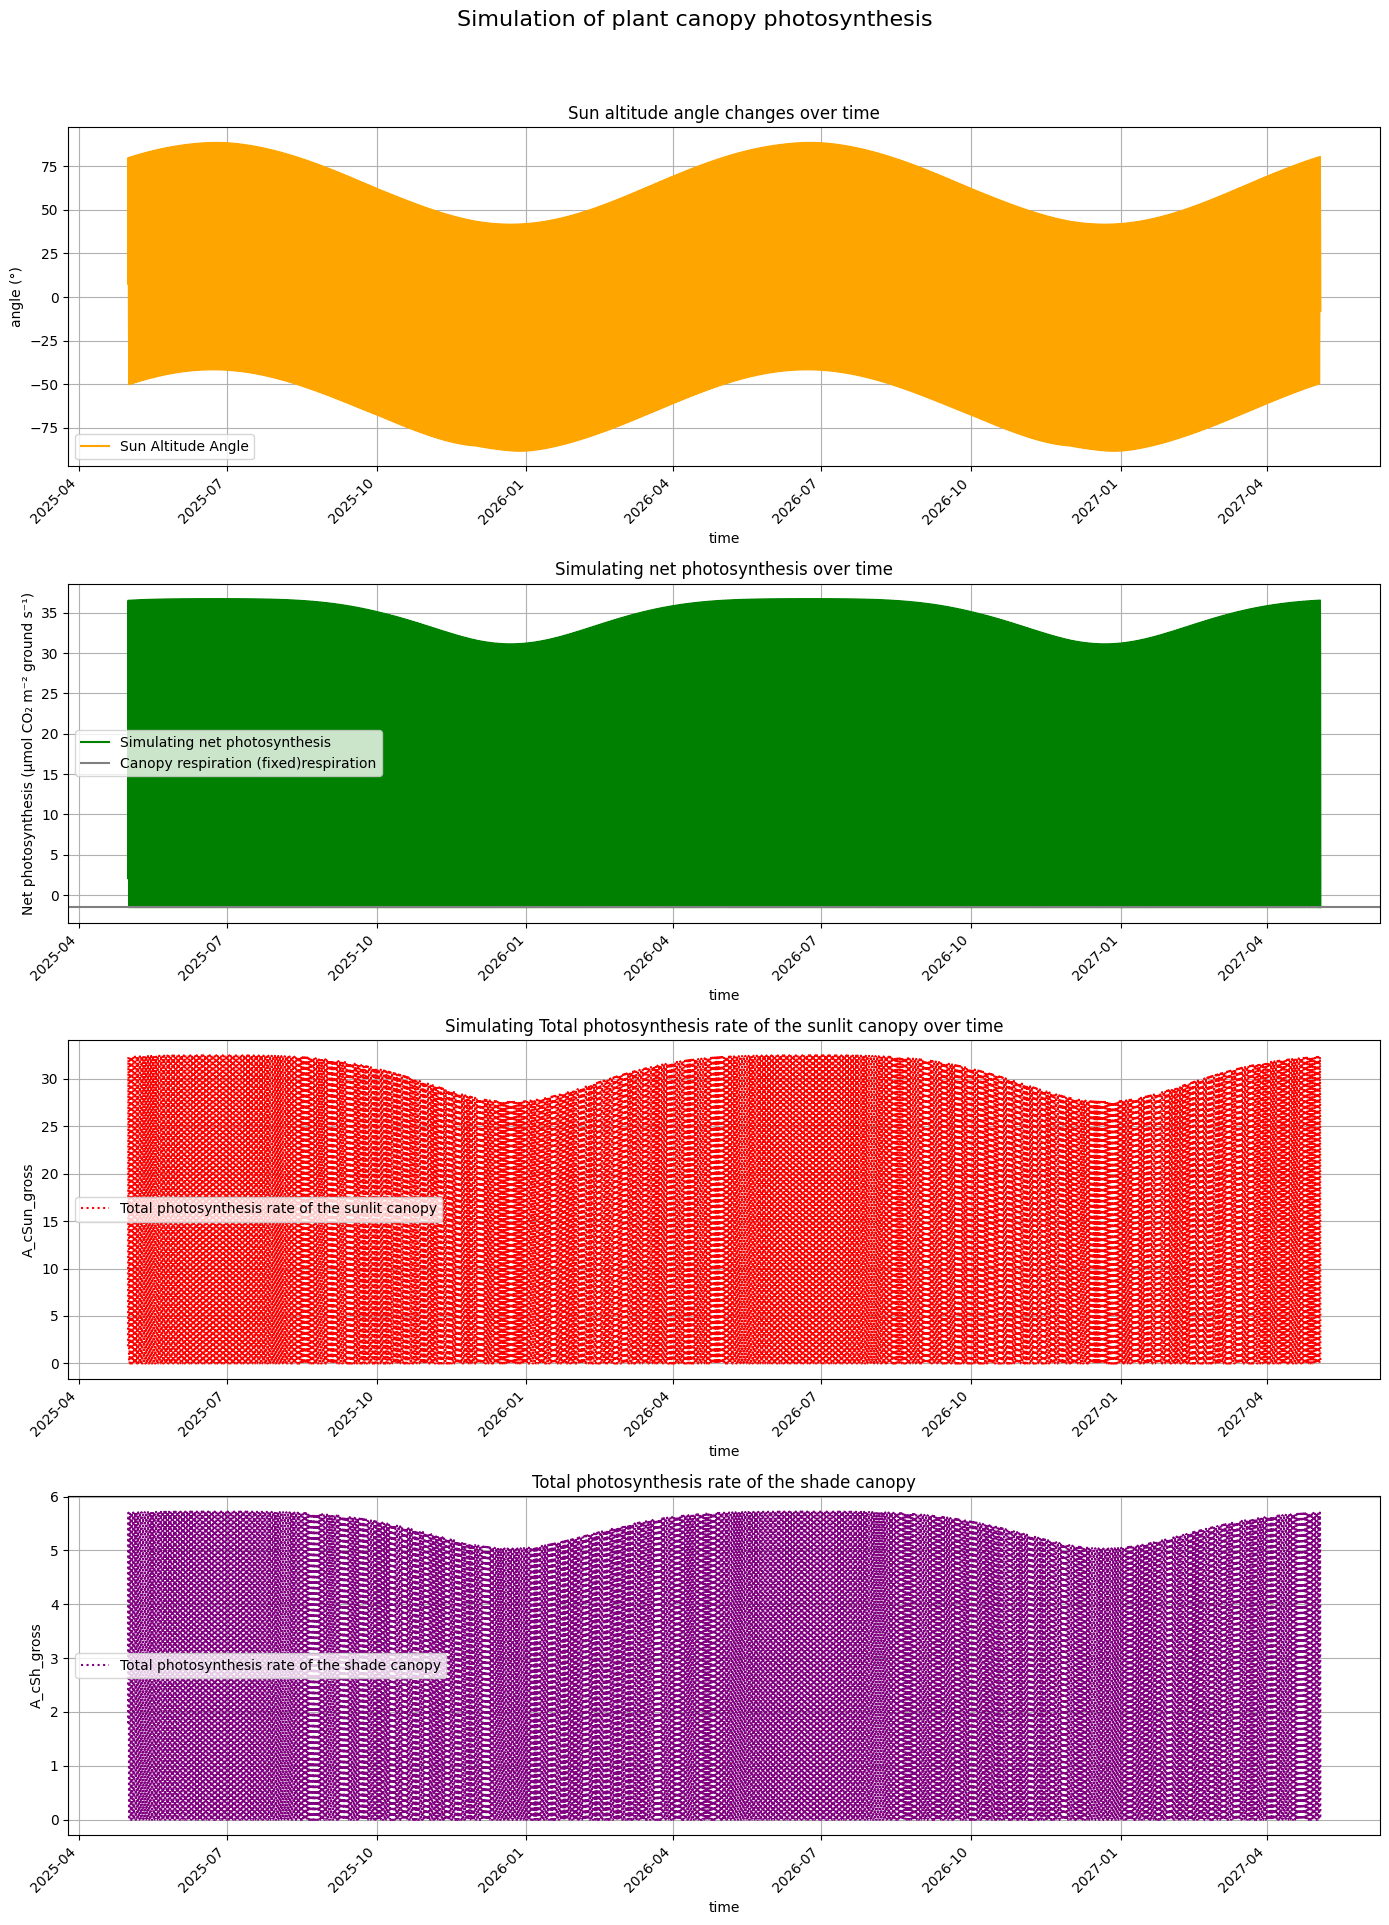

In [ ]:

# --- 第三个代码单元格内容: 核心功能函数: 在时间范围内模拟计算 ---

def simulate_photosynthesis_over_time(
    start_datetime_obj,
    end_datetime_obj,
    time_step_minutes,
    latitude,
    longitude,
    tz_offset_hours,
    default_photosynthesis_params,
    override_photosynthesis_params = None,
    photosynthesis_func = None # 确保你的函数名是正确的
):
    results = []    # 创建一个空列表来存储每次计算的结果
    current_time = start_datetime_obj   # 初始化当前时间为开始时间
    time_delta = timedelta(minutes=time_step_minutes)   # 计算时间步长的时间差对象

    print(f"开始模拟从 {start_datetime_obj} 到 {end_datetime_obj}，间隔 {time_step_minutes} 分钟...")

# 这个循环会重复执行它下面的缩进代码块，只要当前的
    # current_time 还没有超过
    # end_datetime_obj（也就是还在模拟的时间范围内）。
    while current_time <= end_datetime_obj:
    # 当你不知道需要重复执行多少次，但你知道什么时候应该停止（即停止的条件）时，通常使用 while 循环
    # 当你想要遍历一个已知长度的序列，对序列中的每一个元素都做一次相同的操作时，通常使用 for 循环

        # === 步骤 0: 初始化当前时间步的参数 ===
        # 从默认参数开始复制，为当前时间步创建一个独立的参数副本
        current_params = default_photosynthesis_params.copy()
        # 如果有全局覆盖参数，则应用它们
        if override_photosynthesis_params:
            current_params.update(override_photosynthesis_params)

        # === 步骤 1: 计算当前时间点的太阳高度角 ===
        solar_altitude = calculate_solar_altitude_alt( # 确保这个函数名是您实际使用的
            current_time.year,
            current_time.month,
            current_time.day,
            current_time.hour,
            current_time.minute,
            current_time.second,
            latitude,
            longitude,
            tz_offset_hours
        )

        if solar_altitude is None:
            print(f"警告: 计算时间 {current_time} 的太阳高度角失败，跳过。")
            # 如果您有之前因为 IndentationError 修改的代码，确保这里也正确处理
            # 比如，如果您在那里添加了记录部分结果的代码，这里可能也需要类似的逻辑或直接跳过
            current_time += time_delta # 确保时间前进
            continue

        # === 步骤 2: 根据太阳高度角和当前参数估算总入射 PAR ===
        # 参数获取与默认值
        extraterrestrial_par_ie = current_params.get('extraterrestrial_par_ie', 2413.0) # 指大气层外的光合有效辐射
        atmospheric_transmission_a = current_params.get('atmospheric_transmission_a', 0.75) # 表示大气对太阳辐射的削弱程度
        attenuated_to_diffuse_fa = current_params.get('attenuated_to_diffuse_fa', 0.426) # 被大气散射的光（漫射光）占被大气衰减掉的直射光的比例
        pressure_ratio_P_P0 = current_params.get('pressure_ratio_P_P0', 1.0) # 当前气压与标准气压的比值

        # 初始化为 0
        Ib0 = 0.0
        Id0 = 0.0
        estimated_total_incident_par = 0.0

        if solar_altitude > 0:  # 只有当太阳高度角大于 0 时（即太阳升起，有光照时），才会进行 PAR 计算
            beta_radians = math.radians(solar_altitude)
            sin_beta = max(1e-6, math.sin(beta_radians))
            optical_air_mass_m = pressure_ratio_P_P0 / sin_beta # 太阳光线穿过的大气层厚度
            am = atmospheric_transmission_a ** optical_air_mass_m # 太阳辐射在穿过大气层后保留下来的比例
            Ib0 = extraterrestrial_par_ie * am * sin_beta # 计算直射 PAR
            Id0 = attenuated_to_diffuse_fa * (1.0 - am) * extraterrestrial_par_ie * sin_beta # 计算直射 PAR
            estimated_total_incident_par = Ib0 + Id0 # 计算总入射 PAR

        Ib0 = max(0.0, Ib0)
        Id0 = max(0.0, Id0)
        estimated_total_incident_par = max(0.0, estimated_total_incident_par)

        # === 步骤 3: 更新 current_params 中随时间变化的特定值 ===
        # 将当前时间步计算得到的环境变量（例如直射光、散射光、太阳高度角和总 PAR）动态地加入到 current_params 字典中
        current_params['Ib0'] = Ib0
        current_params['Id0'] = Id0
        current_params['beta_degrees'] = solar_altitude
        current_params['total_incident_par_top'] = estimated_total_incident_par

        # 如果需要根据时间动态改变 T_celsius 或 Ci_ppm，可以在这里更新 current_params
        # 例如: current_params['T_celsius'] = some_function_to_get_temp(current_time)

        # === 步骤 4: 调用光合作用函数 ===
        # 确保 photosynthesis_func 指向您实际的光合作用计算函数
        if photosynthesis_func is None: # 添加一个检查，以防未正确传递函数
            print(f"错误: 未指定 photosynthesis_func。在时间 {current_time} 跳过光合作用计算。")
            photosynthesis_output = {} # 或其他适当的默认/空结果
        else:
            photosynthesis_output = photosynthesis_func(params=current_params, verbose=False)


        # === 步骤 5: 存储结果 ===
        # (这里的代码应该与您修复 IndentationError 后的版本一致)
        time_result_base = {
            'Time': current_time,
            'Solar_Altitude_deg': solar_altitude,
            'Estimated_Total_Incident_PAR': estimated_total_incident_par,
            'Ib0_calculated': Ib0,
            'Id0_calculated': Id0,
            'Calculated_Diffuse_Fraction': Id0 / estimated_total_incident_par if estimated_total_incident_par > 1e-9 else 0.0,
        }

        if photosynthesis_output is None or not isinstance(photosynthesis_output, dict):
            print(f"警告: 光合作用函数在时间 {current_time} 返回无效结果。仅存储部分环境数据。")
            # 如果 photosynthesis_output 无效，可以选择不合并或合并一个空字典
            # 这里我们只存储基础信息
            results.append(time_result_base)
        else:
            time_result_base.update(photosynthesis_output) # 合并光合作用函数的输出
            results.append(time_result_base)

        # 移动到下一个时间点
        current_time += time_delta

    print("模拟完成。")
    return pd.DataFrame(results)

# --- 示例如何使用 simulate_photosynthesis_over_time ---

# 1. 定义时间范围和间隔
start_time = datetime(2025, 5, 1, 6, 0, 0) # 2025年5月1日 早上6:00
end_time = datetime(2027, 5, 3, 19, 0, 0)    # 2027年5月1日 下午6:00
time_step = 30 # 间隔 14400 分钟

# 2. 定义地点信息 (台北)
site_latitude = 25.0
site_longitude = 121.0
site_tz_offset = 8.0 # GMT+8



# 6. 运行模拟
# 确保 photosynthesis_func 指向你的实际光合作用函数名
simulation_results_df = simulate_photosynthesis_over_time(
    start_datetime_obj = start_time,
    end_datetime_obj = end_time,
    time_step_minutes = time_step,
    latitude = site_latitude,
    longitude = site_longitude,
    tz_offset_hours = site_tz_offset,
    default_photosynthesis_params = default_model_params,
    override_photosynthesis_params = override_model_params_for_simulation,
    photosynthesis_func = calculate_sunshade_canopy_photosynthesis # 确保这里是你实际的函数名
)

# 7. 查看结果 (前/后几行)
print("\n--- 模拟结果 (前5行) ---")
print(simulation_results_df.head())

print("\n--- 模拟结果 (后5行) ---")
print(simulation_results_df.tail())

# 8. 绘制结果
plt.figure(figsize=(14, 20)) # 调整图形大小

# 绘制太阳高度角
plt.subplot(4, 1, 1) # 图表的布局。它表示创建一个包含 2 行 1 列子图的网格，当前要绘制的是第一个子图
plt.plot(simulation_results_df['Time'], simulation_results_df['Solar_Altitude_deg'], label='Sun Altitude Angle', color='orange')
plt.xlabel('time')
plt.ylabel('angle (°)')
plt.title('Sun altitude angle changes over time')
plt.grid(True) # 在图表上添加网格，便于读取数值
plt.legend() # 显示图例，解释不同曲线的含义（在这里只有一条曲线）
plt.xticks(rotation=45, ha='right') # 旋转x轴标签避免重叠
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 自动调整布局，留出底部空间给主标题
                       # rect 参数可以为子图保留额外的空间，例如，这里 [0, 0.03, 1, 0.95] 意味着在底部留出 3% 的空间，顶部留出 5% 的空间

# 绘制净光合作用结果
plt.subplot(4, 1, 2) # 绘制第2个图
# 检查 'Ac_net' 列是否存在
if 'Ac_net' in simulation_results_df.columns:
    plt.plot(simulation_results_df['Time'], simulation_results_df['Ac_net'], color='green', label='Simulating net photosynthesis')
    plt.ylabel('Net photosynthesis (μmol CO₂ m⁻² ground s⁻¹)') # 使用您函数中的单位描述
    # 可选：添加总Gross、Sun Gross、Shade Gross 曲线
    # if 'Ac_gross_total' in simulation_results_df.columns:
    #      plt.plot(simulation_results_df['Time'], simulation_results_df['Ac_gross_total'], color='blue', linestyle='--', label='总 Gross 光合作用')
    # if 'A_cSun_gross' in simulation_results_df.columns:
    #      plt.plot(simulation_results_df['Time'], simulation_results_df['A_cSun_gross'], color='red', linestyle=':', label='受光部分 Gross 光合作用')
    # if 'A_cSh_gross' in simulation_results_df.columns:
    #      plt.plot(simulation_results_df['Time'], simulation_results_df['A_cSh_gross'], color='purple', linestyle=':', label='遮荫部分 Gross 光合作用')
    if 'Rc' in override_model_params_for_simulation:
        plt.axhline(y=-override_model_params_for_simulation['Rc'], linestyle='-', color='gray', label='Canopy respiration (fixed)respiration')
    elif 'Rc' in default_model_params:
        plt.axhline(y=-default_model_params['Rc'], color='gray', linestyle='-', label='Canopy respiration (fixed)respiration')

else:
    # 如果没有 'Ac_net'，打印警告并显示一个提示文本
    print("\n警告: 结果 DataFrame 中未找到 'Ac_net' 列，无法绘制净光合作用曲线。")
    print("请检查您的光合作用函数返回的字典是否包含 'Ac_net' 键。")
    plt.text(0.5, 0.5, "无法找到 'Ac_net' 列\n请检查光合作用函数返回值",
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, color='red', fontsize=10)
    plt.ylabel('数据缺失')


plt.xlabel('time')
plt.title('Simulating net photosynthesis over time')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45, ha='right') # 旋转x轴标签避免重叠
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 自动调整布局，避免图间重叠

# 绘制受光部分（Sunlit）冠层总光合作用速率结果
plt.subplot(4, 1, 3) # 绘制第3个图
if 'A_cSun_gross' in simulation_results_df.columns:
    plt.plot(simulation_results_df['Time'], simulation_results_df['A_cSun_gross'], color='red', linestyle=':', label='Total photosynthesis rate of the sunlit canopy')
    plt.ylabel('A_cSun_gross')
else:
    # 如果没有 'Ac_net'，打印警告并显示一个提示文本
    print("\n警告: 结果 DataFrame 中未找到 'A_cSun_gross' 列，无法绘制受光部分（Sunlit）冠层总光合作用曲线。")
    print("请检查您的光合作用函数返回的字典是否包含 'A_cSun_gross' 键。")
    plt.text(0.5, 0.5, "无法找到 'A_cSun_gross' 列\n请检查光合作用函数返回值",
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, color='red', fontsize=10)
    plt.ylabel('数据缺失')

plt.xlabel('time')
plt.title('Simulating Total photosynthesis rate of the sunlit canopy over time')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45, ha='right') # 旋转x轴标签避免重叠
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 自动调整布局，避免图间重叠

# 遮荫部分（Shade）冠层总光合作用速率
plt.subplot(4, 1, 4) # 绘制第4个图
if 'A_cSh_gross' in simulation_results_df.columns:
    plt.plot(simulation_results_df['Time'], simulation_results_df['A_cSh_gross'], color='purple', linestyle=':', label='Total photosynthesis rate of the shade canopy')
    plt.ylabel('A_cSh_gross')
else:
    # 如果没有 'Ac_net'，打印警告并显示一个提示文本
    print("\n警告: 结果 DataFrame 中未找到 'A_cSh_gross' 列，无法绘制遮荫部分（Shade）冠层总光合作用速率曲线。")
    print("请检查您的光合作用函数返回的字典是否包含 'A_cSh_gross' 键。")
    plt.text(0.5, 0.5, "无法找到 'A_cSh_gross' 列\n请检查光合作用函数返回值",
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, color='red', fontsize=10)
    plt.ylabel('数据缺失')

plt.xlabel('time')
plt.title('Total photosynthesis rate of the shade canopy')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45, ha='right') # 旋转x轴标签避免重叠
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 自动调整布局，避免图间重叠


# 添加一个总标题
plt.suptitle('Simulation of plant canopy photosynthesis', fontsize=16, y=0.99)

# 显示图形
plt.show()

In [ ]:
import pandas as pd
import numpy as np

def calculate_average_annual_yield(results_df):
    """
    计算模拟结果 DataFrame 中的年平均累积净光合产量。

    函数会计算模拟的总时长，并将总产量除以总时长（年）。
    'Ac_net' 列应为净光合速率，单位 μmol CO₂ m⁻² ground s⁻¹。

    Args:
        results_df (pd.DataFrame): 包含模拟结果的 pandas DataFrame，
                                    必须包含 'Time' 和 'Ac_net' 列。

    Returns:
        float: 年平均累积净光合产量，单位 g C m⁻² yr⁻¹。
               如果 DataFrame 无效或缺少关键列/数据，或模拟时长无效，则返回 0.0。
    """
    # 1. 检查输入 DataFrame 是否有效
    if not isinstance(results_df, pd.DataFrame) or results_df.empty:
        print("错误: 输入不是有效的或空的 DataFrame。")
        return 0.0

    if 'Time' not in results_df.columns or 'Ac_net' not in results_df.columns:
        print("错误: 输入 DataFrame 必须包含 'Time' 和 'Ac_net' 列。")
        return 0.0

    # 2. 确保 'Ac_net' 是数值类型
    ac_net_series = pd.to_numeric(results_df['Ac_net'], errors='coerce')

    # 检查是否有任何有效的光合作用数据
    if ac_net_series.isnull().all():
        print("警告: 'Ac_net' 列中没有有效数据。")
        return 0.0

    # 3. 计算时间步长 (单位：秒)
    # 假设时间步长均匀
    try:
        valid_times = results_df['Time'].dropna()
        if len(valid_times) < 2:
            print("错误: 无法从 'Time' 列确定时间步长 (至少需要两个有效时间点)。")
            return 0.0 # 无法确定步长，产量为0

        # 使用前两个有效时间点计算步长
        dt_seconds = (valid_times.iloc[1] - valid_times.iloc[0]).total_seconds()

        if dt_seconds <= 0:
             print(f"错误: 计算出的时间步长无效或非正数 ({dt_seconds} 秒)。")
             return 0.0 # 无效步长，产量为0

    except Exception as e:
        print(f"错误计算时间步长: {e}")
        return 0.0 # 错误发生，产量为0


    # 4. 计算累积净光合作用总量 (单位：μmol CO₂ m⁻²)
    # 'Ac_net' 单位是 μmol/s，乘以时间步长(秒) 得到每个步长固定的 μmol 量
    # 对所有步长固定的 μmol 量求和 (sum() 会自动忽略 NaN)
    total_umol_co2_fixed = ac_net_series.sum() * dt_seconds

    # 5. 将 μmol CO₂ 转换为克碳 (g C)
    conversion_factor_gC_per_umolCO2 = 12.01 / 1e6 # g C / μmol CO₂
    total_yield_gC_m2 = total_umol_co2_fixed * conversion_factor_gC_per_umolCO2

    # 6. 计算模拟的总时长 (单位：年)
    try:
        # 至少需要两个有效时间点才能确定时长范围
        valid_times = results_df['Time'].dropna()
        if len(valid_times) < 2:
            print("错误: 模拟时间范围太短，无法计算年平均。")
            return 0.0

        simulation_start_time = valid_times.iloc[0]
        simulation_end_time = valid_times.iloc[-1]
        simulation_duration_seconds = (simulation_end_time - simulation_start_time).total_seconds()

        # 避免除以零或接近零
        if simulation_duration_seconds <= 1e-9:
             print("警告: 模拟时长接近零，无法计算年平均。")
             return 0.0

        # 将总秒数转换为年 (使用平均年长 365.25 天)
        seconds_per_year = 365.25 * 24 * 3600
        simulation_duration_years = simulation_duration_seconds / seconds_per_year

    except Exception as e:
        print(f"错误计算模拟时长: {e}")
        return 0.0


    # 7. 计算年平均产量
    # 总产量 (g C m⁻²) 除以总时长 (年) 得到年平均产量 (g C m⁻² yr⁻¹)
    average_annual_yield_gC_m2_yr = total_yield_gC_m2 / simulation_duration_years

    return average_annual_yield_gC_m2_yr

# --- 如何在模拟两年后使用这个函数 ---

# 假设您已经将模拟时间范围设置为两年，例如：
# start_time = datetime(2025, 5, 1, 6, 0, 0)
# end_time = datetime(2027, 5, 1, 6, 0, 0) # 两年后的同一时刻

# 然后运行模拟，得到 simulation_results_df

# simulation_results_df = simulate_photosynthesis_over_time(...)

# 调用新的函数计算年平均产量
average_annual_yield = calculate_average_annual_yield(simulation_results_df)

# 打印结果
print(f"\n估算的年平均累积净光合产量: {average_annual_yield:.2f} g C m⁻² yr⁻¹")


估算的年平均累积净光合产量: 4176.73 g C m⁻² yr⁻¹


In [ ]:
import pandas as pd # 导入 pandas，如果需要处理 NaN 或 None 输入的话

# --- 新代码框：将光合产量从质量单位转换为能量单位 (kJ) ---

def convert_yield_gC_to_energy_kJ(yield_gC_m2, energy_per_gC_kJ_per_gC=40.0):
    """
    将光合产量从 g C m⁻² (或其他时间单位) 转换为能量单位 (kJ m⁻²)。

    Args:
        yield_gC_m2 (float): 以 g C m⁻² (或其他时间单位，取决于输入) 为单位的累积或平均光合产量。
                             例如，如果输入是 g C m⁻² yr⁻¹，输出就是 kJ m⁻² yr⁻¹。
        energy_per_gC_kJ_per_gC (float): 将 1 克碳转换为能量的因子，单位 kJ/g C。
                                         默认值 40.0 kJ/g C 是一个常用近似值。
                                         实际值会因生物质类型不同而异 (通常在 40 - 45 kJ/gC 之间)。

    Returns:
        float: 以 kJ m⁻² (或其他时间单位) 为单位的光合产量。
               例如，如果输入是 g C m⁻² yr⁻¹，输出就是 kJ m⁻² yr⁻¹。
               如果输入产量为负或 NaN，返回相应值。
    """
    # 检查输入是否为 None 或 NaN
    if yield_gC_m2 is None or (isinstance(yield_gC_m2, (int, float)) and pd.isna(yield_gC_m2)):
        return yield_gC_m2 # 如果输入是 None 或 NaN，直接返回

    # 确保转换因子非负
    if energy_per_gC_kJ_per_gC < 0:
         print("警告: 能量转换因子不应为负。使用默认值 40.0 kJ/g C。")
         energy_per_gC_kJ_per_gC = 40.0 # 回退到默认值

    # 转换计算: 产量 (g C / Area / Time) * 能量/质量 (kJ / g C) = 能量 / Area / Time (kJ / Area / Time)
    yield_energy_m2 = yield_gC_m2 * energy_per_gC_kJ_per_gC

    return yield_energy_m2

# --- 示例如何使用这个函数 ---
# 假设您已经计算出了 g C 单位的产量
# example_yield_gC_m2_yr = 1000.0 # 示例年产量 1000 g C m⁻² yr⁻¹ (例如使用 calculate_average_annual_yield 得到的结果)

# 使用默认转换因子 (40 kJ/g C) 将产量转换为能量单位 (kJ m⁻² yr⁻¹)
annual_yield_kJ_m2_yr = convert_yield_gC_to_energy_kJ(average_annual_yield)

# 打印结果
print(f"年累积净光合产量 (能量单位): {annual_yield_kJ_m2_yr:.2f} kJ m⁻² yr⁻¹")

# 您也可以指定不同的转换因子，例如使用 42 kJ/g C
# annual_yield_kJ_m2_yr_alt = convert_yield_gC_to_energy_kJ(example_yield_gC_m2_yr, energy_per_gC_kJ_per_gC=42.0)
# print(f"使用 42 kJ/gC 转换因子估算的示例年累积净光合产量 (能量单位): {annual_yield_kJ_m2_yr_alt:.2f} kJ m⁻² yr⁻¹")

年累积净光合产量 (能量单位): 167069.09 kJ m⁻² yr⁻¹


In [ ]:
import math

# --- 模型参数和常数 ---

# 年累积净光合产量 (ANPP)，来自您提供的数据 (kJ m⁻² yr⁻⁻¹)
ANNUAL_NPP_KJ_M2_YR = annual_yield_kJ_m2_yr

# 假设分配给草食者的 NPP 比例
NPP_TO_HERBIVORE_EFFICIENCY = 0.05

# 瓦特 (W) 到 千焦/年 (kJ/年) 的转换常数 (基于 365.25 天/年)
WATTS_TO_KJ_PER_YEAR = 31557.6

# 异速生长标度参数 (基础代谢率 BMR = Y0 * M^b)
# BMR 单位为 kJ/年，体质量 M 单位为 kg
# 这些是基于文献中常见估算值和单位转换的示例。
# 实际值因具体物种、生理状态、测量方法等因素差异很大，这里的数值仅供演示。
ALLOMETRIC_SCALING_PARAMS = {
    '哺乳类': {
        'Y0': 3.4 * WATTS_TO_KJ_PER_YEAR, # 基于约 3.4 W/kg^0.75 的常见哺乳动物 BMR
        'b': 0.75,
        'description': '基于哺乳动物基础代谢率估算 (约 3.4 W/kg^0.75)',
        'mass_unit_info': '请输入体质量 (kg)'
    },
    '鸟类': {
        'Y0': 0.0346 * WATTS_TO_KJ_PER_YEAR, # 基于约 0.0346 W/kg^0.669 的鸟类 BMR
        'b': 0.669,
        'description': '基于鸟类基础代谢率估算 (约 0.0346 W/kg^0.669)',
        'mass_unit_info': '请输入体质量 (kg)'
    },
    '昆虫': {
        # 基于一项研究中约 4.14 µl O2/h / g^0.66 的昆虫 RMR 估算，并转换为 kJ/年和 kg。
        # 转换过程涉及能量当量假设 (1 µl O2 ≈ 20.1 J) 和单位转换 (g 到 kg, 小时到年)。
        # 1 µl O2/h ≈ 176.1966 kJ/年
        # (4.14 µl O2/h / g^0.66) * (176.1966 kJ/年 / µl O2/h) / (1000 g/kg)^0.66
        'Y0': (4.14 * 176.1966) / (1000**0.66), # 约 69643
        'b': 0.66,
        'description': '基于昆虫静息代谢率估算 (约 4.14 µl O2/h / g^0.66，单位转换有假设)',
        'mass_unit_info': '请输入体质量 (kg)'
    }
}

# --- 函数定义 ---

def get_animal_type_input():
    """获取用户输入的动物类型并进行验证"""
    while True:
        animal_type = input("请输入希望计算的动物类型 (哺乳类, 鸟类, 昆虫): ").strip()
        if animal_type in ALLOMETRIC_SCALING_PARAMS:
            return animal_type
        else:
            print("输入无效。请从 '哺乳类', '鸟类', '昆虫' 中选择。")

def get_positive_float_input(prompt):
    """获取用户输入的正浮点数并进行验证"""
    while True:
        try:
            value = float(input(prompt))
            if value > 0:
                return value
            else:
                print("输入必须是一个大于零的数字。")
        except ValueError:
            print("输入无效。请输入一个有效的数字。")

def calculate_bmr_kjer_from_kg(animal_type, mass_kg):
    """根据动物类型和体质量 (kg) 计算其基础代谢率 (kJ/年)"""
    params = ALLOMETRIC_SCALING_PARAMS[animal_type]
    y0 = params['Y0']
    b = params['b']

    # 使用异速生长公式计算 BMR (kJ/年)
    bmr_kjer = y0 * (mass_kg ** b)

    return bmr_kjer

def calculate_carrying_capacity(total_available_energy_kj_yr, individual_annual_energy_kj_yr):
    """计算承载能力（能养活的个体数量）"""
    if individual_annual_energy_kj_yr <= 0:
        return 0 # 避免除以零或负能量需求

    number_of_individuals = total_available_energy_kj_yr / individual_annual_energy_kj_yr

    return number_of_individuals

# --- 主程序 ---

print("--- 森林草食者承载能力估算模型 ---")
print(f"假设年累积净光合产量 (ANPP) 为: {ANNUAL_NPP_KJ_M2_YR} kJ m⁻² yr⁻¹")
print(f"假设只有 {NPP_TO_HERBIVORE_EFFICIENCY * 100}% 的 ANPP 可供草食者利用。")
print("-" * 30)

# 获取用户输入
selected_animal_type = get_animal_type_input()
animal_mass_kg = get_positive_float_input(ALLOMETRIC_SCALING_PARAMS[selected_animal_type]['mass_unit_info'] + ": ")
forest_area_m2 = get_positive_float_input("请输入森林的总面积 (单位：m²): ")
bmr_coefficient = get_positive_float_input("请输入基础代谢率（BMR）要乘以的系数（考虑活动、消化等，通常大于1）：")

# --- 执行计算 ---
try:
    # 获取选定动物类型的异速生长参数和描述
    params = ALLOMETRIC_SCALING_PARAMS[selected_animal_type]
    param_description = params['description']

    # 计算个体基础代谢率 (BMR)
    individual_bmr_kjer = calculate_bmr_kjer_from_kg(selected_animal_type, animal_mass_kg)

    # 计算个体年总能量需求
    individual_annual_energy_kjer = individual_bmr_kjer * bmr_coefficient

    # 计算森林年可供草食者利用的总能量
    total_available_energy_kj_yr = ANNUAL_NPP_KJ_M2_YR * forest_area_m2 * NPP_TO_HERBIVORE_EFFICIENCY

    # 计算承载能力
    carrying_capacity = calculate_carrying_capacity(total_available_energy_kj_yr, individual_annual_energy_kjer)

    # --- 输出结果 ---
    print("\n--- 计算结果 ---")
    print(f"选择的动物类型: {selected_animal_type}")
    print(f"个体平均体质量: {animal_mass_kg:.4f} kg")
    print(f"森林总面积: {forest_area_m2:.2f} m²")
    print(f"BMR 乘法系数: {bmr_coefficient:.2f}")
    print("-" * 30)
    print(f"使用的异速生长参数 (Y0={params['Y0']:.4g}, b={params['b']:.3g}):")
    print(f"  {param_description}")
    print(f"估算的个体基础代谢率 (BMR): {individual_bmr_kjer:.2f} kJ/年")
    print(f"个体年总能量需求 (BMR * 系数): {individual_annual_energy_kjer:.2f} kJ/年")
    print(f"森林年可供草食者利用的总能量 (5% NPP): {total_available_energy_kj_yr:.2f} kJ/年")
    print("-" * 30)
    print(f"根据估算，该森林能养活约 {carrying_capacity:.2f} 个 {selected_animal_type} 个体。")

except Exception as e:
    print(f"\n计算过程中发生错误: {e}")

print("\n--- 模型局限性声明 ---")
print("此模型是一个高度简化的能量流转模型，估算结果仅供参考。未考虑多种生态因素（如食物选择性、竞争、捕食、疾病、领地、栖息地异质性等）。异速生长参数是基于平均值，具体物种可能存在差异。估算结果仅供参考。")

--- 森林草食者承载能力估算模型 ---
假设年累积净光合产量 (ANPP) 为: 167069.09265183407 kJ m⁻² yr⁻¹
假设只有 5.0% 的 ANPP 可供草食者利用。
------------------------------
请输入希望计算的动物类型 (哺乳类, 鸟类, 昆虫): 鸟类
请输入体质量 (kg): 1
请输入森林的总面积 (单位：m²): 10000
请输入基础代谢率（BMR）要乘以的系数（考虑活动、消化等，通常大于1）：2

--- 计算结果 ---
选择的动物类型: 鸟类
个体平均体质量: 1.0000 kg
森林总面积: 10000.00 m²
BMR 乘法系数: 2.00
------------------------------
使用的异速生长参数 (Y0=1092, b=0.669):
  基于鸟类基础代谢率估算 (约 0.0346 W/kg^0.669)
估算的个体基础代谢率 (BMR): 1091.89 kJ/年
个体年总能量需求 (BMR * 系数): 2183.79 kJ/年
森林年可供草食者利用的总能量 (5% NPP): 83534546.33 kJ/年
------------------------------
根据估算，该森林能养活约 38252.17 个 鸟类 个体。

--- 模型局限性声明 ---
此模型是一个高度简化的能量流转模型，估算结果仅供参考。未考虑多种生态因素（如食物选择性、竞争、捕食、疾病、领地、栖息地异质性等）。异速生长参数是基于平均值，具体物种可能存在差异。估算结果仅供参考。


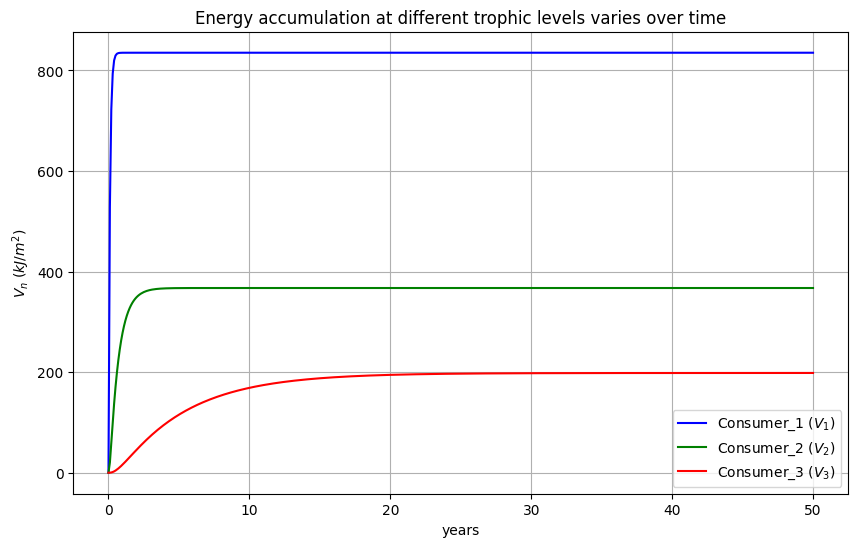


--- 模拟结果 (稳态近似值) ---
初级消费者累积能量 (V1): 835.35 kJ/m^2
次级消费者累积能量 (V2): 367.38 kJ/m^2
最高消费者累积能量 (V3): 198.39 kJ/m^2
10 1.5916664576598605 0.206307787836071

--- 稳态能量金字塔比例 ---
次级/初级 (V2/V1): 0.44
最高/次级 (V3/V2): 0.54


In [ ]:
# 导入所需的库
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# 定义微分方程组
def energy_flow_model(V, t, I1, k1, k2, k3, T1, T2 ):
    """
    能量在三个营养级中流动的模型。

    参数:
        V (list): 当前时刻各营养级的能量 [V1, V2, V3]
        t (float): 当前时间
        I1 (float): 输入到初级消费者的能量速率
        k1, k2, k3 (float): 各营养级的总能量流出速率常数
        T1, T2 (float): 能量从上一级总输出到下一级输入的传递效率

    返回值:
        list: 各营养级能量随时间的变化率 [dV1/dt, dV2/dt, dV3/dt]
    """
    V1, V2, V3 = V

    # 确保能量不为负数，尽管在大多数情况下模型参数会保持它们为正
    V1 = max(0, V1)
    V2 = max(0, V2)
    V3 = max(0, V3)

    # 计算各营养级的总流出速率
    #Out_1 = o1 + I2
    #Out_2 = o2 + I3

    Out_1 = k1 * V1
    Out_2 = k2 * V2
    Out_3 = k3 * V3

    # 计算输入到次级和最高消费者的能量速率
    I2 = T1 * Out_1
    I3 = T2 * Out_2

    # 计算各营养级能量随时间的变化率
    dV1dt = I1 - Out_1
    dV2dt = I2 - Out_2
    dV3dt = I3 - Out_3

    return [dV1dt, dV2dt, dV3dt]

# --- 设定模型参数 ---
# 假设 NPP 为 annual_yield_kJ_m2_yr
NPP = annual_yield_kJ_m2_yr

# I1: 输入到初级消费者的能量速率 (NPP 的 5%)
I1 = 0.05 * NPP  # J/m^2/year

# T1, T2: 能量从上一级总输出到下一级输入的传递效率 (设定为 7%)
T1 = 0.07
T2 = 0.07

# k1, k2, k3: 各营养级的总能量流出速率常数 (反映周转速率，通常 k1 > k2 > k3)
# 这里设定一些示例值，体现低营养级周转快，高营养级周转慢
k1 = 10   # 例如，年周转 1 次
k2 = k1**(3/4) * 0.07 * NPP**(0.25) * 5**-1
k3 = k1**(9/16) * 0.0049 * NPP**(7/16) * 5**(-7/4)

# 将参数打包
params = (I1, k1, k2, k3, T1, T2)

# --- 设定初始条件 ---
# 初始时刻各营养级的能量累积量设为 0
initial_V = [0, 0, 0] # [V1(0), V2(0), V3(0)]

# --- 设定时间范围 ---
# 模拟时间从 0 到 50 年 (可以根据需要调整)
t_span = np.linspace(0, 50, 501) # 生成 501 个时间点用于计算和绘图

# --- 求解微分方程组 ---
# 使用 odeint 函数进行数值积分
solution = odeint(energy_flow_model, initial_V, t_span, args=params)

# 提取各营养级的能量随时间的变化结果
V1_t = solution[:, 0]
V2_t = solution[:, 1]
V3_t = solution[:, 2]

# --- 绘图 ---
plt.figure(figsize=(10, 6))

plt.plot(t_span, V1_t, label='Consumer_1 ($V_1$)', color='blue')
plt.plot(t_span, V2_t, label='Consumer_2 ($V_2$)', color='green')
plt.plot(t_span, V3_t, label='Consumer_3 ($V_3$)', color='red')

plt.xlabel('years')
plt.ylabel('$V_n$ ($kJ/m^2$)')
plt.title('Energy accumulation at different trophic levels varies over time')
plt.legend()
plt.grid(True)
plt.show()

# 打印稳态下的能量累积量 (如果达到稳态)
# 稳态时，V_steady_state = I_steady_state / k
# I1_steady = I1
# I2_steady = T1 * k1 * V1_steady
# I3_steady = T2 * k2 * V2_steady
# V1_steady = I1 / k1
# V2_steady = I2_steady / k2 = (T1 * k1 * (I1 / k1)) / k2 = T1 * I1 / k2
# V3_steady = I3_steady / k3 = (T2 * k2 * V2_steady) / k3 = (T2 * k2 * (T1 * I1 / k2)) / k3 = T1 * T2 * I1 / k3

# 从模拟结果中获取最后的数值作为稳态近似值
V1_steady_sim = V1_t[-1]
V2_steady_sim = V2_t[-1]
V3_steady_sim = V3_t[-1]

print(f"\n--- 模拟结果 (稳态近似值) ---")
print(f"初级消费者累积能量 (V1): {V1_steady_sim:.2f} kJ/m^2")
print(f"次级消费者累积能量 (V2): {V2_steady_sim:.2f} kJ/m^2")
print(f"最高消费者累积能量 (V3): {V3_steady_sim:.2f} kJ/m^2")
print(k1 , k2 , k3)

# 计算稳态下的生物量 (能量) 金字塔比例
print(f"\n--- 稳态能量金字塔比例 ---")
if V1_steady_sim > 0:
    print(f"次级/初级 (V2/V1): {V2_steady_sim / V1_steady_sim:.2f}")
if V2_steady_sim > 0:
    print(f"最高/次级 (V3/V2): {V3_steady_sim / V2_steady_sim:.2f}")